In [1]:
import pandas as pd 
from pymongo import MongoClient
import matplotlib.pyplot as plt
import time
import datetime
from IPython.display import clear_output
from scipy.interpolate import make_interp_spline
import numpy as np 

In [2]:
client = MongoClient()
client.DallasPD_DB
db = client['DallasPD_DB']
dpd_db = db.running_db
df = pd.DataFrame(list(dpd_db.find()))

In [3]:
df = pd.DataFrame(list(dpd_db.find()))
df.columns
dfc = df.drop('_id', axis = 1)
dfc = dfc.drop_duplicates()
dfc.sort_values(by = ['date', 'time']).head()
dfc['datetime'] = pd.to_datetime(dfc['date'].astype(str) + ' ' + dfc['time'])
dfc['day'] = dfc['datetime'].dt.day

In [4]:
# get non unique incidents 
all_incidents = dfc['incident_number'].to_list()
incident_dict = {}
for incident in all_incidents:
    if incident in incident_dict.keys():
        incident_dict[incident] = incident_dict[incident] + 1
    else:
        incident_dict[incident] = 1
        
advanced_incidents = []
for i in incident_dict:
    if incident_dict[i] >1:
        advanced_incidents.append(i)
dfc[dfc['incident_number']=='25-0285764']
# https://dallaspolice.net/resources/CrimeReports/Calls%20by%20Problem%20Type.pdf

,incident_number,division,nature_of_call,priority,date,time,unit_number,location,beat,reporting_area,status,block,datetime,day
16,25-0285764,Southeast,41/11V - BMV-In Progress,2,2025-02-17,23:31:39,E383,Stonehurst St,333,1253,At Scene,8100,2025-02-17 23:31:39,17
17,25-0285764,Southeast,41/11V - BMV-In Progress,2,2025-02-17,23:31:39,E372,Stonehurst St,333,1253,At Scene,8100,2025-02-17 23:31:39,17
18,25-0285764,Southeast,41/11V - BMV-In Progress,2,2025-02-17,23:31:39,K6,Stonehurst St,333,1253,At Scene,8100,2025-02-17 23:31:39,17
19,25-0285764,Southeast,41/11V - BMV-In Progress,2,2025-02-17,23:31:39,E332,Stonehurst St,333,1253,At Scene,8100,2025-02-17 23:31:39,17
20,25-0285764,Southeast,41/11V - BMV-In Progress,2,2025-02-17,23:31:39,UAS34,Stonehurst St,333,1253,At Scene,8100,2025-02-17 23:31:39,17
21,25-0285764,Southeast,41/11V - BMV-In Progress,2,2025-02-17,23:31:39,E380,Stonehurst St,333,1253,At Scene,8100,2025-02-17 23:31:39,17
22,25-0285764,Southeast,41/11V - BMV-In Progress,2,2025-02-17,23:31:39,E316,Stonehurst St,333,1253,At Scene,8100,2025-02-17 23:31:39,17


1 60


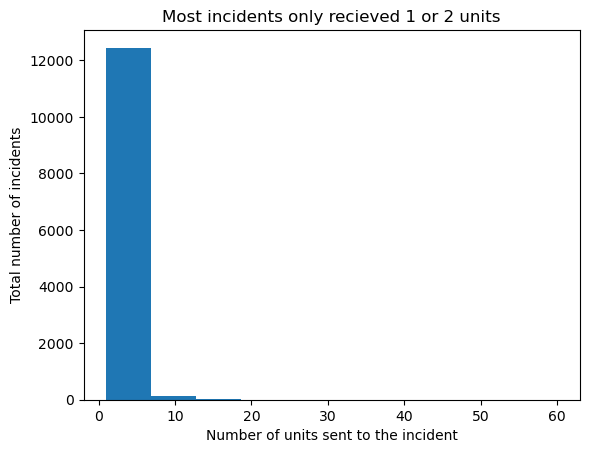

In [5]:
plt.hist(incident_dict.values(), bins = 10)
plt.title("Most incidents only recieved 1 or 2 units")
plt.xlabel('Number of units sent to the incident')
plt.ylabel('Total number of incidents')
print(min(incident_dict.values()), max(incident_dict.values()))

In [6]:
def incidents_by_num_units(num_units, equals_to):
    if equals_to:
        filtered_dict = {key: value for key, value in incident_dict.items() if value == num_units}
    else:
        filtered_dict = {key: value for key, value in incident_dict.items() if value >= num_units}
    return filtered_dict

def subset_df(incident_numbers):
    return dfc[dfc['incident_number'].isin(incident_numbers.keys())].sort_values(by = ['incident_number', 'unit_number'])

In [7]:
subset_df(incidents_by_num_units(13, False))['incident_number'].unique()

array(['25-0286372', '25-0292252', '25-0308863', '25-0318532',
       '25-0356764', '25-0359032', '25-0366296', '25-0373249',
       '25-0373298', '25-0380122', '25-0389314', '25-0392457',
       '25-0393319', '25-0397582', '25-0398954', '25-0412652'],
      dtype=object)

In [8]:
dfc.groupby(['date']).agg('count')['incident_number']

date
2025-02-17      31
2025-02-18    1229
2025-02-19     760
2025-02-20     746
2025-02-21     854
2025-02-22     717
2025-02-23     567
2025-02-24     606
2025-02-25     674
2025-02-26     671
2025-02-27    1296
2025-02-28     795
2025-03-01     796
2025-03-02     754
2025-03-03    1394
2025-03-04    1179
2025-03-05     669
2025-03-06    1005
2025-03-07    1546
2025-03-08    1734
2025-03-09    1696
2025-03-10     347
Name: incident_number, dtype: int64

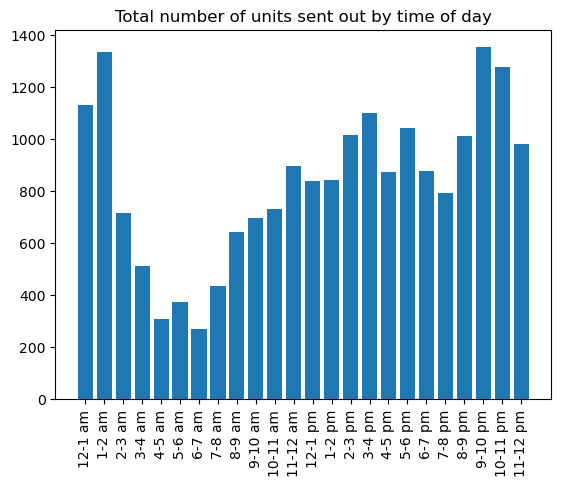

In [9]:
# Total number of units sent out by time of day 
units_by_hour = dfc.groupby(dfc['datetime'].dt.hour).agg('count')[['incident_number']]
units_by_hour= units_by_hour.reset_index()
units_by_hour = units_by_hour.sort_values(by= 'datetime')
x = units_by_hour['datetime']
y = units_by_hour['incident_number']
plt.bar(x, y, tick_label=["12-1 am", "1-2 am", "2-3 am", "3-4 am", "4-5 am", "5-6 am", "6-7 am", "7-8 am", "8-9 am", "9-10 am", "10-11 am", "11-12 am", "12-1 pm", "1-2 pm", "2-3 pm", "3-4 pm", "4-5 pm", "5-6 pm", "6-7 pm", "7-8 pm", "8-9 pm", "9-10 pm", "10-11 pm", "11-12 pm"])
plt.xticks(rotation = 90)
plt.title("Total number of units sent out by time of day")
plt.show()

In [10]:
# number of incidents by time of day 
"""
interesting because it shows the variety of police activity for each category 
ex between midnight and 1 am there have been 50 unique incidents, 7 divisions hving incidents, 
23 different call natures, 4 different priority levels, ..... in the past 3 days
"""
dfc['hour'] = dfc['datetime'].dt.hour
dfc['minute'] = dfc['datetime'].dt.minute
dfc['priority'] = pd.to_numeric(dfc['priority'], errors='coerce')
incidents_by_hour = dfc.groupby(['hour']).nunique('incident_number')
incidents_by_hour.head()

,incident_number,division,nature_of_call,priority,date,time,unit_number,location,beat,reporting_area,status,block,datetime,day,minute
hour,,,,,,,,,,,,,,,
0,686,7,64,4,17,621,402,493,211,415,1,136,681,17,60
1,750,7,64,4,16,673,383,549,217,449,1,139,747,16,60
2,421,7,58,4,15,396,319,335,182,300,1,126,420,15,60
3,302,7,52,4,13,297,241,247,158,239,1,107,301,13,59
4,187,7,50,4,12,177,170,169,118,163,1,85,184,12,58


In [11]:
mean_hourly_activity = dfc.groupby(['hour', 'date']).nunique().groupby(['hour']).mean()
mean_hourly_activity.drop(axis ='columns', columns = ['time', 'status', 'datetime'], inplace = True)
mean_hourly_activity.head()
# block - is crime/ police dispatch more centered/consistent in certain areas - mapping/modeling 

# mean number of-/ mean -
mean_hourly_activity.rename(columns={"incident_number":"incidents", "division":"divisions", "nature_of_call":"call types", "unit_number":"units sent", "location": "locations", "beat":"beats", "reporting_area":"reporting area's"}, inplace =True)              
mean_hourly_activity.reset_index(inplace = True)

In [12]:
# mean number of units dispatched per incident per hour 
mean_upi_ph = dfc.groupby(['hour', 'date', 'incident_number']).nunique().groupby(['hour']).mean()['unit_number']
mean_upi_ph

hour
0     1.647230
1     1.781333
2     1.698337
3     1.692053
4     1.652406
5     1.603448
6     1.582353
7     1.501718
8     1.438479
9     1.529670
10    1.518672
11    1.522034
12    1.652259
13    1.479789
14    1.540909
15    1.502046
16    1.455907
17    1.619565
18    1.537653
19    1.577689
20    1.644481
21    1.647202
22    1.702667
23    1.643813
Name: unit_number, dtype: float64

In [13]:
mean_hourly_activity.head(10)

,hour,incidents,divisions,call types,priority,units sent,locations,beats,reporting area's,block,day,minute
0,0,40.352941,6.352941,16.000000,3.588235,55.882353,38.294118,35.588235,38.000000,28.705882,1.0,25.823529
1,1,46.875000,6.562500,18.250000,3.687500,64.875000,45.250000,40.437500,43.937500,33.125000,1.0,30.750000
2,2,28.066667,5.866667,12.733333,3.200000,39.333333,26.866667,24.800000,26.666667,20.933333,1.0,19.466667
3,3,23.230769,4.615385,11.307692,2.769231,31.692308,22.230769,21.000000,22.153846,17.384615,1.0,17.230769
4,4,15.583333,3.833333,8.000000,2.583333,20.750000,15.416667,13.250000,14.750000,12.083333,1.0,12.000000
5,5,19.333333,4.583333,9.166667,2.916667,26.166667,19.000000,17.833333,18.666667,13.916667,1.0,14.833333
6,6,14.166667,4.750000,8.583333,3.000000,19.416667,13.666667,13.083333,13.666667,11.083333,1.0,11.666667
7,7,16.166667,4.833333,9.166667,2.833333,22.555556,16.055556,15.055556,15.944444,11.833333,1.0,12.611111
8,8,23.526316,5.473684,10.947368,3.210526,29.368421,22.894737,21.105263,22.210526,17.526316,1.0,17.368421
9,9,23.947368,6.000000,11.578947,3.263158,32.526316,23.631579,21.947368,22.789474,17.210526,1.0,17.894737


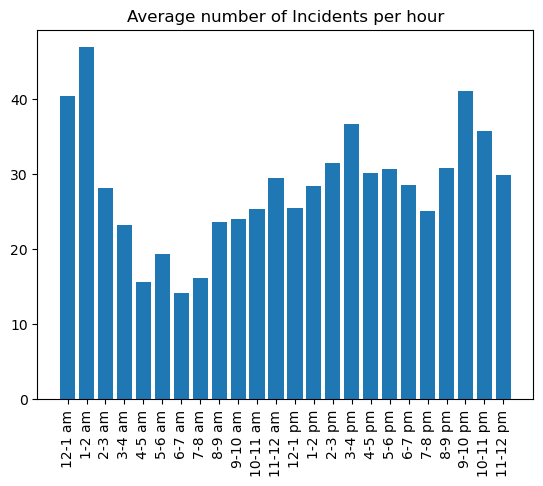

In [14]:
# mean number of incident by time of day 
mha_incidents = mean_hourly_activity[['hour', 'incidents']].sort_values(by='hour')
x = mha_incidents['hour']
y = mha_incidents['incidents']
plt.bar(x, y, tick_label=["12-1 am", "1-2 am", "2-3 am", "3-4 am", "4-5 am", "5-6 am", "6-7 am", "7-8 am", "8-9 am", "9-10 am", "10-11 am", "11-12 am", "12-1 pm", "1-2 pm", "2-3 pm", "3-4 pm", "4-5 pm", "5-6 pm", "6-7 pm", "7-8 pm", "8-9 pm", "9-10 pm", "10-11 pm", "11-12 pm"])
plt.xticks(rotation = 90)
plt.title("Average number of Incidents per hour")
plt.show()

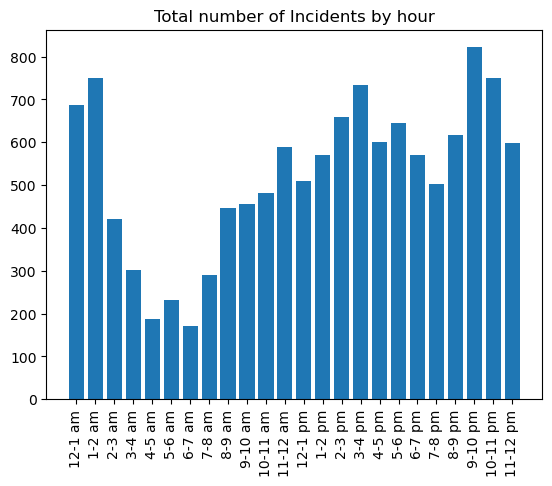

In [15]:
# Total number of incidents per hour 
incidents_by_hour = dfc.groupby(['hour'])['incident_number'].nunique().groupby('hour').sum().reset_index()
x = incidents_by_hour['hour']
y = incidents_by_hour['incident_number']
plt.bar(x, y, tick_label=["12-1 am", "1-2 am", "2-3 am", "3-4 am", "4-5 am", "5-6 am", "6-7 am", "7-8 am", "8-9 am", "9-10 am", "10-11 am", "11-12 am", "12-1 pm", "1-2 pm", "2-3 pm", "3-4 pm", "4-5 pm", "5-6 pm", "6-7 pm", "7-8 pm", "8-9 pm", "9-10 pm", "10-11 pm", "11-12 pm"])
plt.xticks(rotation = 90)
plt.title("Total number of Incidents by hour")
plt.show()

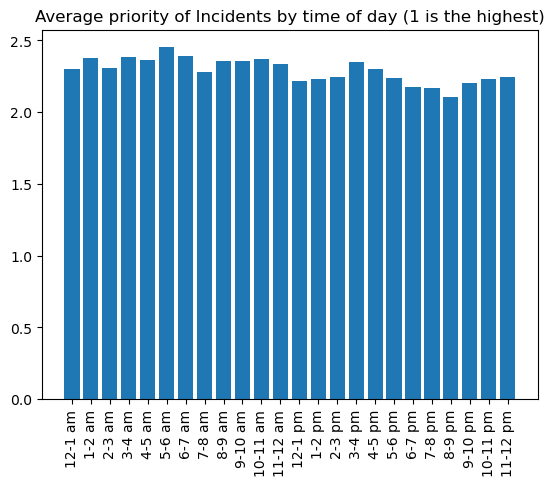

In [16]:
mean_hourly_activity = dfc.groupby(['hour', 'date','incident_number'])[['priority']].mean().groupby(['hour'])['priority'].mean()
mean_hourly_activity = mean_hourly_activity.reset_index()
x = mean_hourly_activity['hour']
y = mean_hourly_activity['priority']
plt.bar(x, y, tick_label=["12-1 am", "1-2 am", "2-3 am", "3-4 am", "4-5 am", "5-6 am", "6-7 am", "7-8 am", "8-9 am", "9-10 am", "10-11 am", "11-12 am", "12-1 pm", "1-2 pm", "2-3 pm", "3-4 pm", "4-5 pm", "5-6 pm", "6-7 pm", "7-8 pm", "8-9 pm", "9-10 pm", "10-11 pm", "11-12 pm"])
plt.xticks(rotation = 90)
plt.title("Average priority of Incidents by time of day (1 is the highest)")
plt.show()

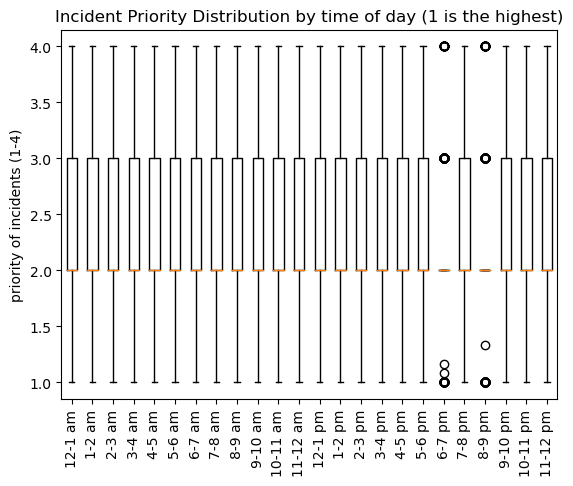

In [17]:
mean_hourly_activity = dfc.groupby(['hour', 'date','incident_number'])[['priority']].mean()
mean_hourly_activity  = mean_hourly_activity.reset_index().groupby('hour')['priority'].apply(list).to_dict()
fig, ax = plt.subplots()
ax.set_ylabel('priority of incidents (1-4)')
bplot = ax.boxplot(mean_hourly_activity.values(),
                   labels=["12-1 am", "1-2 am", "2-3 am", "3-4 am", "4-5 am", "5-6 am", "6-7 am", "7-8 am", "8-9 am", "9-10 am", "10-11 am", "11-12 am", "12-1 pm", "1-2 pm", "2-3 pm", "3-4 pm", "4-5 pm", "5-6 pm", "6-7 pm", "7-8 pm", "8-9 pm", "9-10 pm", "10-11 pm", "11-12 pm"])  # will be used to label x-ticks
plt.xticks(rotation = 90)
plt.title("Incident Priority Distribution by time of day (1 is the highest)")
plt.show()

In [18]:
# most prevalent call types 
call_counts = dfc.groupby('nature_of_call')['incident_number'].agg('count').reset_index().sort_values(by='incident_number', ascending = False)
call_counts_gt_20 = call_counts[call_counts['incident_number']>=20]['nature_of_call'].tolist()
len(call_counts_gt_20)

71

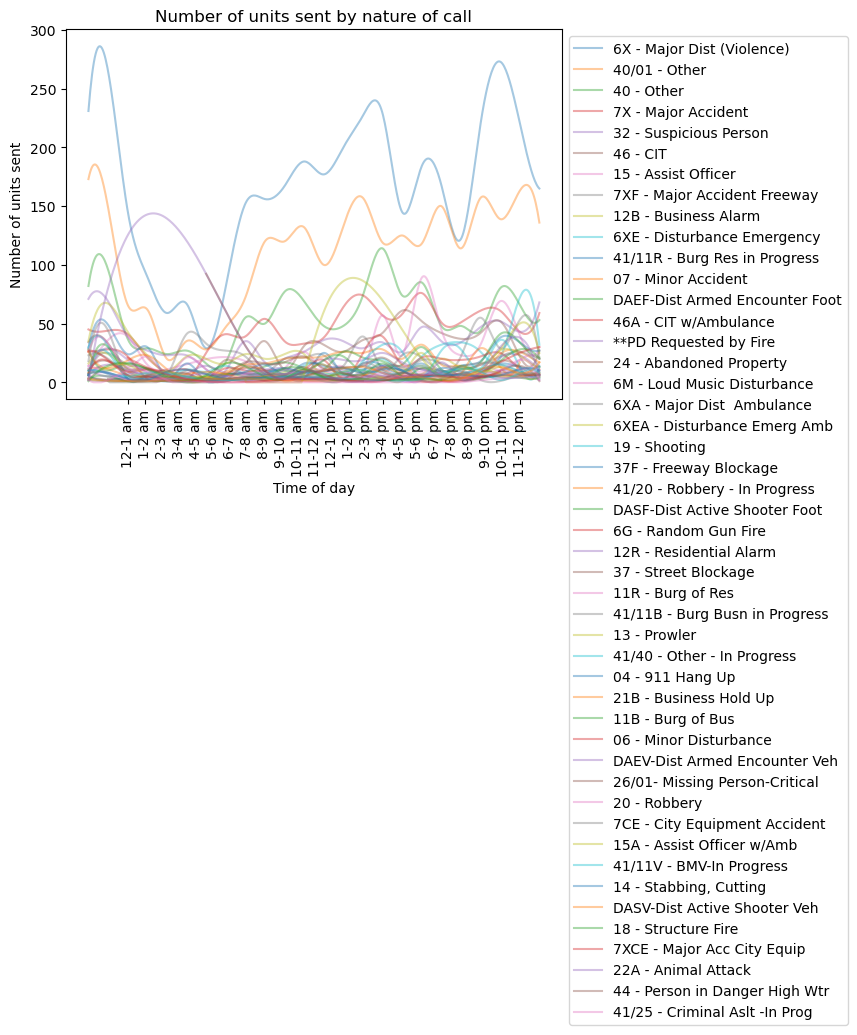

In [20]:
# call type trends 
# can dig into call types by time of day 
# dfc.groupby(['nature_of_call', 'hour'])['incident_number'].agg('count').reset_index().sort_values(by=['hour', 'incident_number'], ascending = False)

#number of units sent per hour per call nature 
for call in call_counts_gt_20:
    call_df = dfc[dfc['nature_of_call']==call].groupby('hour')['incident_number'].agg('count').reset_index()
    overlapping = 0.4
    x = call_df['hour']
    y = call_df['incident_number']
    if max(y.tolist())<10:
        continue
    try:
        X_Y_Spline = make_interp_spline(x, y)
    except:
        pass
    X_ = np.linspace(x.min(), x.max(), 500)
    Y_ = X_Y_Spline(X_)
    Y_ = [0 if val < 0 else val for val in Y_]
    plt.plot(X_, Y_, alpha = overlapping, label=call)
    
plt.legend(loc  ='best', bbox_to_anchor=(1, 1))
hour_labels = ["12-1 am", "1-2 am", "2-3 am", "3-4 am", "4-5 am", "5-6 am", "6-7 am", "7-8 am", "8-9 am", "9-10 am", "10-11 am", "11-12 am", "12-1 pm", "1-2 pm", "2-3 pm", "3-4 pm", "4-5 pm", "5-6 pm", "6-7 pm", "7-8 pm", "8-9 pm", "9-10 pm", "10-11 pm", "11-12 pm"]
tick_positions = np.linspace(x.min(), x.max(), len(hour_labels))
plt.xticks(tick_positions, hour_labels, rotation=90)  # Rotate for better readabilityplt.tight_layout()
plt.title('Number of units sent by nature of call')
plt.xlabel("Time of day")
plt.ylabel("Number of units sent")
plt.show()

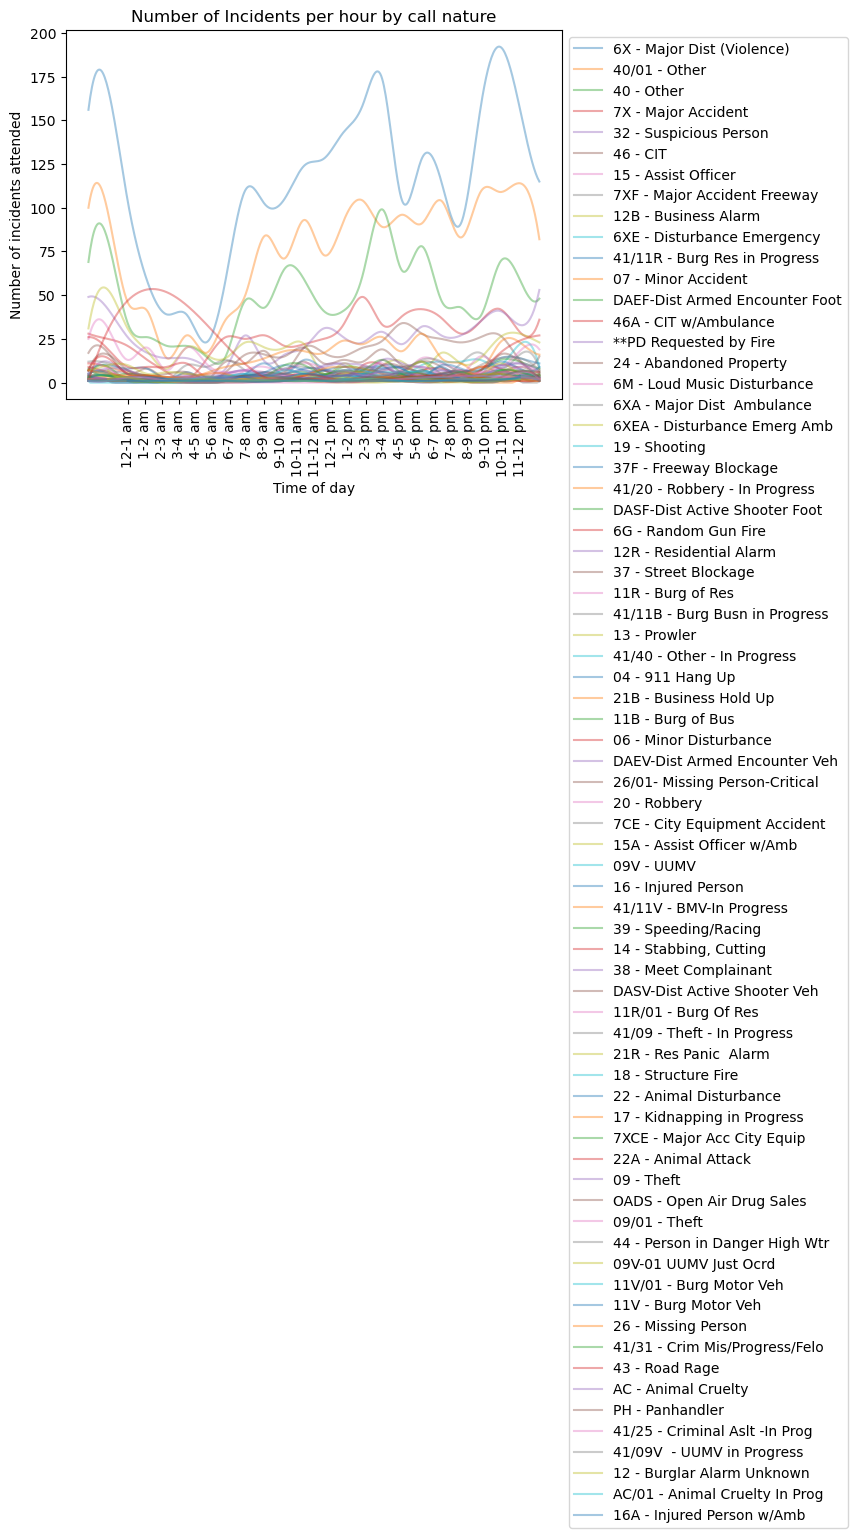

In [22]:
#number of units sent per hour per call nature 
dfu = dfc.drop(columns = ['unit_number'])
dfu = dfu.drop_duplicates()
for call in call_counts_gt_20:
    call_df = dfu[dfu['nature_of_call']==call].groupby('hour')['incident_number'].agg('count').reset_index()
    overlapping = 0.4
    x = call_df['hour']
    y = call_df['incident_number']
    try:
        X_Y_Spline = make_interp_spline(x, y)
    except:
        pass
    X_ = np.linspace(x.min(), x.max(), 500)
    Y_ = X_Y_Spline(X_)
    Y_ = [0 if val < 0 else val for val in Y_]
    plt.plot(X_, Y_, alpha = overlapping, label=call)
    
plt.legend(loc  ='best', bbox_to_anchor=(1, 1))
hour_labels = ["12-1 am", "1-2 am", "2-3 am", "3-4 am", "4-5 am", "5-6 am", "6-7 am", "7-8 am", "8-9 am", "9-10 am", "10-11 am", "11-12 am", "12-1 pm", "1-2 pm", "2-3 pm", "3-4 pm", "4-5 pm", "5-6 pm", "6-7 pm", "7-8 pm", "8-9 pm", "9-10 pm", "10-11 pm", "11-12 pm"]
tick_positions = np.linspace(x.min(), x.max(), len(hour_labels))
plt.xticks(tick_positions, hour_labels, rotation=90)  # Rotate for better readabilityplt.tight_layout()
plt.title('Number of Incidents per hour by call nature')
plt.xlabel("Time of day")
plt.ylabel("Number of incidents attended")
plt.show()

In [23]:
result =  dfc['datetime'].max() - dfc['datetime'].min()
result.days

20

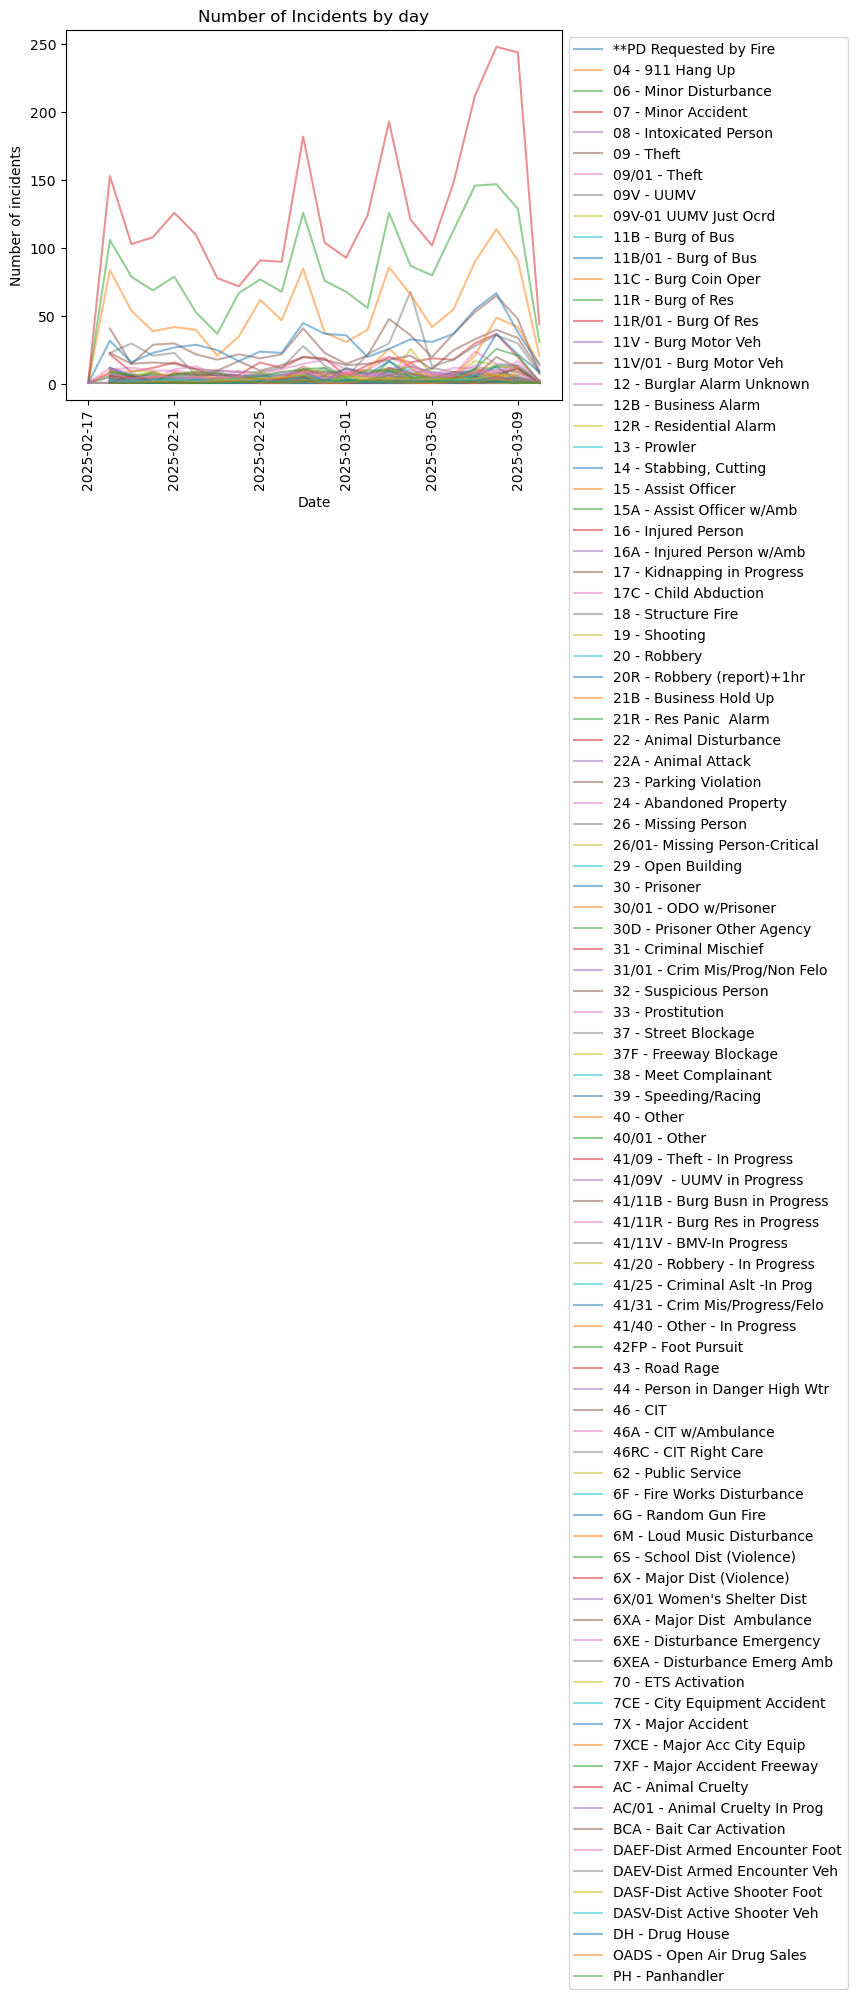

In [24]:
## number of incidents by type by date 
ibd = dfu.groupby(['nature_of_call', 'date'])['incident_number'].agg('count').reset_index().sort_values("nature_of_call")
for call_type in ibd['nature_of_call'].unique().tolist():
    ibd_sub = ibd[ibd['nature_of_call'] == call_type].drop(columns = ['nature_of_call']).sort_values('date')
    plt.plot(ibd_sub['date'], ibd_sub['incident_number'], alpha = .5, label = call_type)
    plt.xticks(rotation=90)
plt.legend(loc  ='best', bbox_to_anchor=(1, 1))
plt.title('Number of Incidents by day')
plt.xlabel("Date")
plt.ylabel("Number of incidents")
plt.show()

In [25]:
dfc[dfc['date'] == "2025-02-18"].groupby('nature_of_call')['incident_number'].agg('count').reset_index().sort_values("incident_number", ascending = False)

,nature_of_call,incident_number
57,6X - Major Dist (Violence),213
42,40/01 - Other,159
41,40 - Other,96
62,7X - Major Accident,69
36,32 - Suspicious Person,62
...,...,...
23,17C - Child Abduction,1
22,16A - Injured Person w/Amb,1
5,09 - Theft,1
4,08 - Intoxicated Person,1


In [26]:
# for past x hours 
def get_date_range(num_days):
    now = datetime.datetime.now()
    day_range = datetime.timedelta(num_days)
    return datetime.datetime.now()-day_range

def get_data_date_range():
    num_days = int(input("get data for the past _ days"))
    start = get_date_range(num_days)
    return dfc[dfc['datetime'] >= start]

In [27]:
get_data_date_range().head()

get data for the past _ days 7


,incident_number,division,nature_of_call,priority,date,time,unit_number,location,beat,reporting_area,status,block,datetime,day,hour,minute
11589,25-0368467,South Central,6X - Major Dist (Violence),2,2025-03-03,04:07:34,A726,Cinnamon Oaks Dr,754,4367,At Scene,6400,2025-03-03 04:07:34,3,4,7
11590,25-0368464,Northwest,6X - Major Dist (Violence),2,2025-03-03,04:09:22,A539,Luna Rd,532,6039,At Scene,10500,2025-03-03 04:09:22,3,4,9
11592,25-0368464,Northwest,6X - Major Dist (Violence),2,2025-03-03,04:09:22,A545,Luna Rd,532,6039,At Scene,10500,2025-03-03 04:09:22,3,4,9
11594,25-0368467,South Central,6X - Major Dist (Violence),2,2025-03-03,04:07:34,E719,Cinnamon Oaks Dr,754,4367,At Scene,6400,2025-03-03 04:07:34,3,4,7
11595,25-0352195,Northwest,24 - Abandoned Property,4,2025-03-03,04:14:39,A546,Denton Dr Cut Off,542,3102,At Scene,5400,2025-03-03 04:14:39,3,4,14


In [28]:
dfu.groupby('date')['incident_number'].agg('count').reset_index()

,date,incident_number
0,2025-02-17,16
1,2025-02-18,756
2,2025-02-19,485
3,2025-02-20,492
4,2025-02-21,531
5,2025-02-22,454
6,2025-02-23,350
7,2025-02-24,377
8,2025-02-25,461
9,2025-02-26,445


# next steps 
- what can this data do to help the pd
    Scheduling, shifts, number of units
    distribution of resources 
    
    

In [29]:
dfc.columns

Index(['incident_number', 'division', 'nature_of_call', 'priority', 'date',
       'time', 'unit_number', 'location', 'beat', 'reporting_area', 'status',
       'block', 'datetime', 'day', 'hour', 'minute'],
      dtype='object')

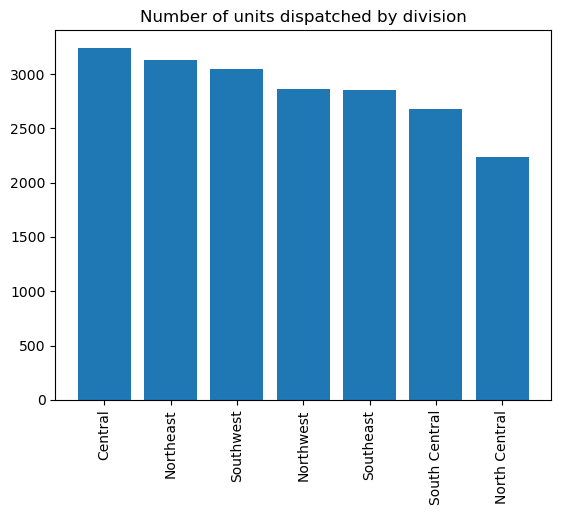

In [30]:
#total number of units dispatched by division 
div_df = dfc.groupby('division')['incident_number'].agg('count').reset_index().sort_values('incident_number', ascending = False)
plt.bar(div_df['division'], div_df['incident_number'])
plt.xticks(rotation=90)
plt.title("Number of units dispatched by division")
plt.show()

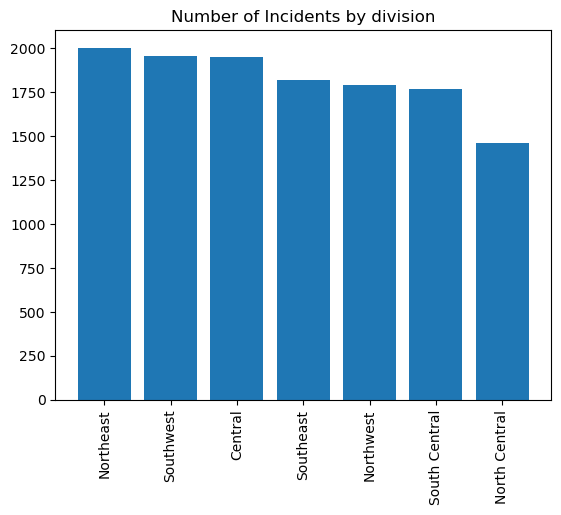

In [31]:
div_df = dfu.groupby('division')['incident_number'].agg('count').reset_index().sort_values('incident_number', ascending = False)
plt.bar(div_df['division'], div_df['incident_number'])
plt.xticks(rotation=90)
plt.title("Number of Incidents by division")
plt.show()

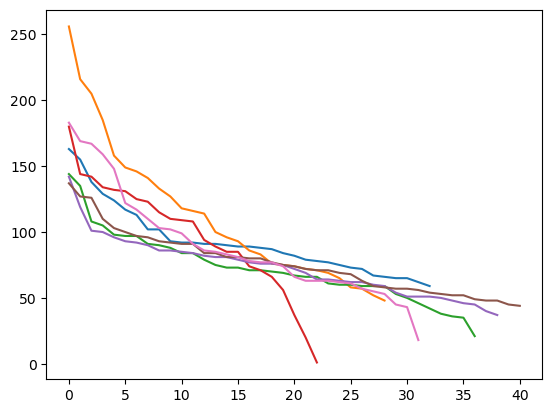

In [32]:
#graphical comparison of number of units being sent out by division, x data aranged from most to least amount by beats 
for division in dfc['division'].unique().tolist(): # 7 divisions 
    temp_df = dfc[dfc['division'] == division].groupby('beat')['incident_number'].agg('count').reset_index().sort_values('incident_number', ascending = False)
    plt.plot(np.arange(len(temp_df)), temp_df['incident_number'])


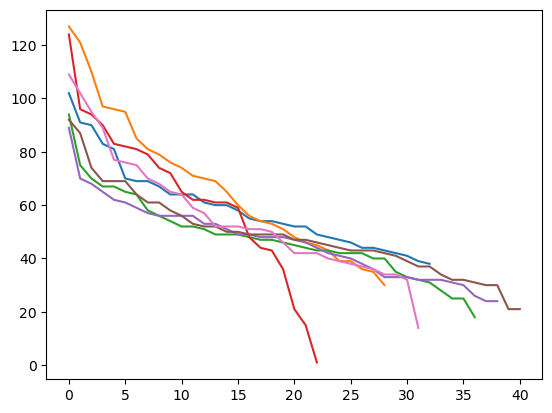

In [33]:
#graphical comparison of number of incidents occuring by division x data aranged from most to least amount by beats 
for division in dfu['division'].unique().tolist(): # 7 divisions 
    temp_df = dfu[dfu['division'] == division].groupby('beat')['incident_number'].agg('count').reset_index().sort_values('incident_number', ascending = False)
    plt.plot(np.arange(len(temp_df)), temp_df['incident_number'])


In [34]:
# how many units needed per district based on current incidents being reported?
for division in dfc['division'].unique().tolist(): # 7 divisions 
    

SyntaxError: incomplete input (3619603022.py, line 3)